# Joint datasets embedding

In this notebook, we showcase how different methods can be applied to perform unsupervised or supervised joint embedding of single-cell datasets.

## Data loading

In [2]:
from transmorph.datasets import load_zhou_10x

datasets = load_zhou_10x()

databank_api > Loading bank zhou_10x.
databank_api > Bank zhou_10x successfully loaded.


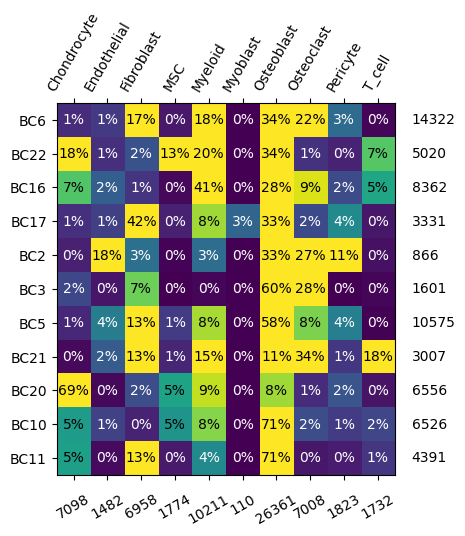

In [3]:
from transmorph.utils.plotting import plot_label_distribution_heatmap

plot_label_distribution_heatmap(datasets, label="class_type")

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm

def get_color(i, palette_size):
    cmap = cm.get_cmap('rainbow')
    return cmap(i/(palette_size-1))

def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

def scatter_plot(figure, datasets, obsm_rep, obs_class, mode="class", legend_on_plot=False, legendtitle=None):
    if not isinstance(datasets, dict):
        datasets = {"": datasets}
        
    X_tot = np.zeros((0,2))
    y_dataset = np.zeros((0,))
    y_class = np.zeros((0,))
    for name, dataset in datasets.items():
        X_tot = np.concatenate((X_tot, dataset.obsm[obsm_rep]), axis=0)
        y_dataset = np.concatenate((y_dataset, [name]*dataset.n_obs), axis=0)
        y_class = np.concatenate((y_class, dataset.obs[obs_class]), axis=0)
        
    if mode == "class":
        y = y_class
    else:
        assert mode == "dataset", f"unrecognized mode: {mode}"
        y = y_dataset
        
    ax = figure.add_subplot(111)
    for i, label in enumerate(sorted(set(y))):
        if label == 'n/a':
            continue
        selector = y == label
        X = X_tot[selector]
        ax.scatter(*X.T, label=label, s=1, color=get_color(i, len(set(y))))
        if legend_on_plot:
            bbox_opt = {
                "facecolor": "white", 
                "edgecolor": "white", 
                "alpha": 0.5, 
                "pad": 0
            }
            plt.text(
                *X.mean(axis=0), 
                label, 
                size="small",
                ha="center", 
                va="center", 
                bbox=bbox_opt
            )
        
    ax.set_xticks([])
    ax.set_yticks([])
    
    if not legend_on_plot:
        # Add a legend
        pos = ax.get_position()
        ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
        maxletters = max([len(str(ylab)) for ylab in set(y)]) # calibrated for figsize(4.5,4)
        ax.legend(
            loc="center right", 
            bbox_to_anchor=(1.66, 0.5), 
            markerscale=5,
            fontsize=14
        )

In [ ]:
from transmorph.utils.plotting import reduce_dimension

reduce_dimension(datasets, output_obsm='base_umap')

Text(0, 0.5, 'UMAP2')

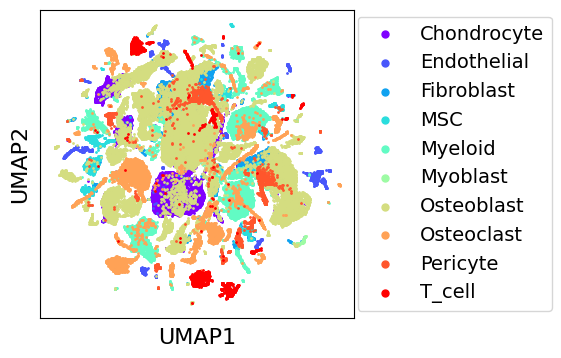

In [11]:
fig = plt.figure(figsize=(4.5,4))
scatter_plot(fig, datasets, "base_umap", "class_type", legendtitle="Cell type")
plt.xlabel("UMAP1", fontsize=16)
plt.ylabel("UMAP2", fontsize=16)

Text(0, 0.5, 'UMAP2')

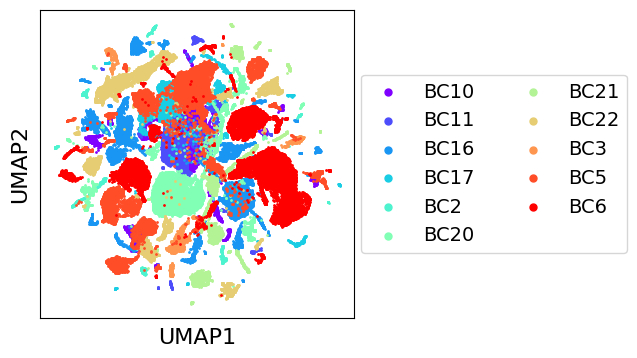

In [28]:
fig = plt.figure(figsize=(4.5,4))
scatter_plot(fig, datasets, "base_umap", "class_type", legendtitle="Dataset", mode="dataset")
plt.xlabel("UMAP1", fontsize=16)
plt.ylabel("UMAP2", fontsize=16)

## Supervised EmbedMNN

### Integration

In [ ]:
from transmorph.models import EmbedMNN

model = EmbedMNN(obs_class="class_type")
model.transform(datasets)

Text(0, 0.5, 'EmbedMNN-2')

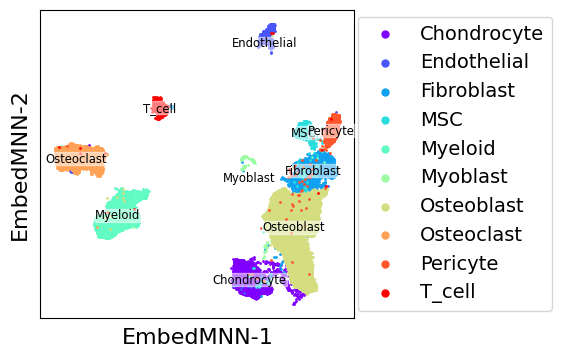

In [17]:
fig = plt.figure(figsize=(4.5,4))
scatter_plot(fig, datasets, "transmorph", "class_type", legend_on_plot=True, legendtitle="Cell type")
plt.xlabel("EmbedMNN-1", fontsize=16)
plt.ylabel("EmbedMNN-2", fontsize=16)

Text(0, 0.5, 'EmbedMNN-2')

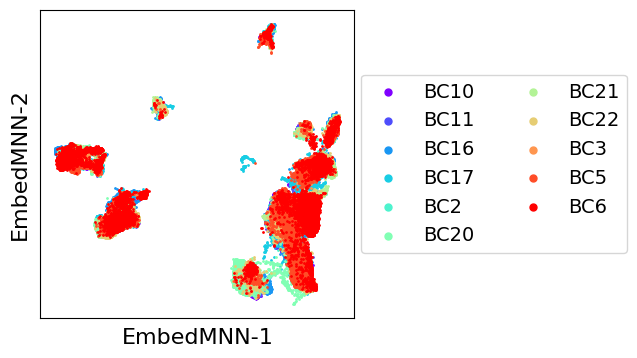

In [27]:
fig = plt.figure(figsize=(4.5,4))
scatter_plot(fig, datasets, "transmorph", "class_type", mode="dataset", legendtitle="Dataset")
plt.xlabel("EmbedMNN-1", fontsize=16)
plt.ylabel("EmbedMNN-2", fontsize=16)

In [ ]:
# Saving results
X_tot = np.zeros((0,2))
for name, dataset in datasets.items():
    X_tot = np.concatenate((X_tot, dataset.obsm["transmorph"]), axis=0)
np.savetxt('data/joint_embedding/embedmnn_supervised.csv', X_tot)

### Clustering

Text(0, 0.5, 'EmbedMNN-2')

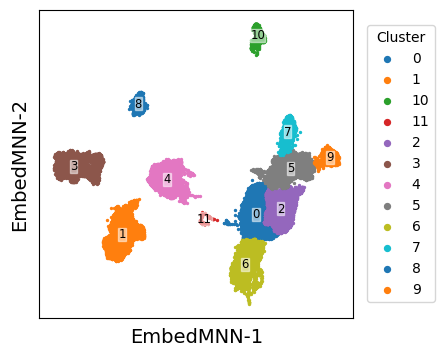

In [65]:
from transmorph.utils.graph import cluster_anndatas

cluster_anndatas(datasets.values(), use_rep="emsup", cluster_key="cluster_emsup", resolution=.025)
for adata in datasets.values():
    adata.obs['cluster_emsup'] = adata.obs['cluster_emsup'].astype(str)
    
fig = plt.figure(figsize=(4.5,4))
scatter_plot(fig, datasets, "emsup", "cluster_emsup", legendtitle="Cluster", legend_on_plot=True)
plt.xlabel("EmbedMNN-1", fontsize=14)
plt.ylabel("EmbedMNN-2", fontsize=14)

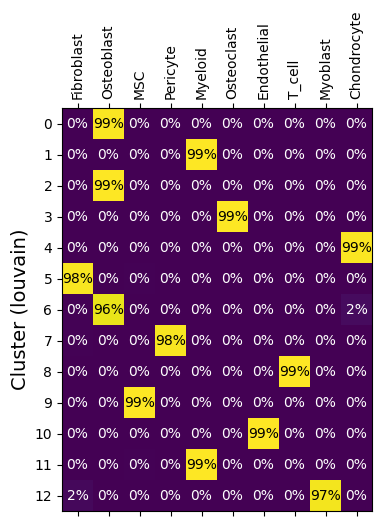

In [62]:
obs_ctype = np.zeros((0,))
obs_cluster = np.zeros((0,))

for name, adata in datasets.items():
    obs_ctype = np.concatenate((obs_ctype, adata.obs['class_type']), axis=0)
    obs_cluster = np.concatenate((obs_cluster, adata.obs['cluster_emsup']), axis=0)

ctypes = set(obs_ctype)
clusters = [str(i) for i in range(len(set(obs_cluster)))]
    
clusters_class = np.zeros((len(clusters), len(ctypes)))
for i, cl in enumerate(clusters):
    items = obs_ctype[obs_cluster == cl]
    for j, ct in enumerate(ctypes):
        clusters_class[i, j] = np.sum(items == ct) / items.shape[0]
  
plt.matshow(clusters_class)
plt.xticks(np.arange(len(ctypes)), ctypes, rotation=90)
plt.yticks(np.arange(len(clusters)), clusters)
plt.ylabel('Cluster (louvain)', fontsize=14)

for i in range(clusters_class.shape[0]):
    for j in range(clusters_class.shape[1]):
        plt.text(
            j, 
            i, 
            f'{int(100*clusters_class[i, j])}%',
            ha='center',
            va='center',
            c=('w' if clusters_class[i, j] < .5 else 'k')
        )
pass

## Unsupervised EmbedMNN

### Integration

In [ ]:
from transmorph.models import EmbedMNN

model = EmbedMNN()
model.transform(datasets)

Text(0, 0.5, 'EmbedMNN-2')

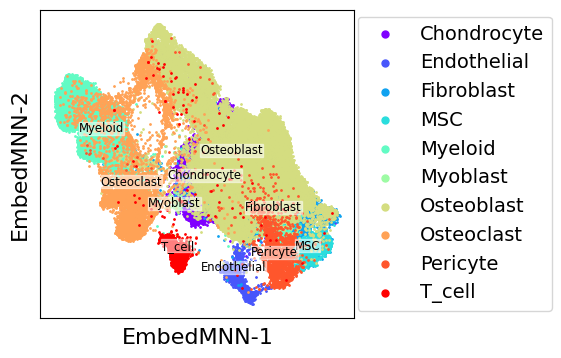

In [32]:
fig = plt.figure(figsize=(4.5,4))
scatter_plot(fig, datasets, "transmorph", "class_type", legend_on_plot=True, legendtitle="Cell type")
plt.xlabel("EmbedMNN-1", fontsize=16)
plt.ylabel("EmbedMNN-2", fontsize=16)

Text(0, 0.5, 'EmbedMNN-2')

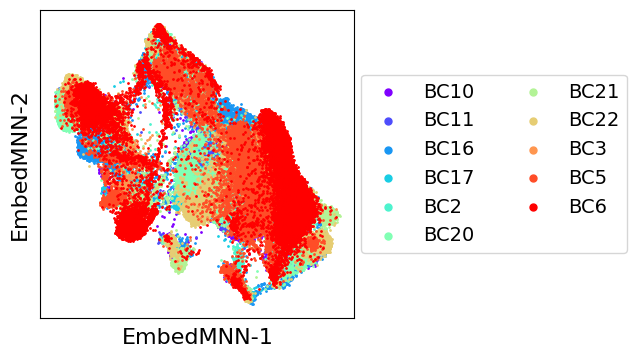

In [30]:
fig = plt.figure(figsize=(4.5,4))
scatter_plot(fig, datasets, "transmorph", "class_type", mode="dataset", legendtitle="Dataset")
plt.xlabel("EmbedMNN-1", fontsize=16)
plt.ylabel("EmbedMNN-2", fontsize=16)

In [95]:
# Saving results
X_tot = np.zeros((0,2))
for name, dataset in datasets.items():
    X_tot = np.concatenate((X_tot, dataset.obsm["transmorph"]), axis=0)
np.savetxt('data/joint_embedding/embedmnn_unsupervised.csv', X_tot)

### Clustering

Text(0, 0.5, 'EmbedMNN-2')

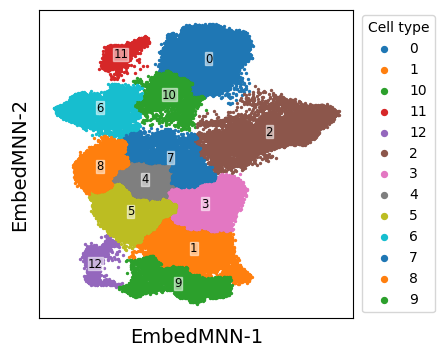

In [72]:
from transmorph.utils.graph import cluster_anndatas

cluster_anndatas(datasets.values(), use_rep="emuns", cluster_key="cluster_emuns", resolution=.05)
for adata in datasets.values():
    adata.obs['cluster_emuns'] = adata.obs['cluster_emuns'].astype(str)
    
fig = plt.figure(figsize=(4.5,4))
scatter_plot(fig, datasets, "emuns", "cluster_emuns", legendtitle="Cell type", legend_on_plot=True)
plt.xlabel("EmbedMNN-1", fontsize=14)
plt.ylabel("EmbedMNN-2", fontsize=14)

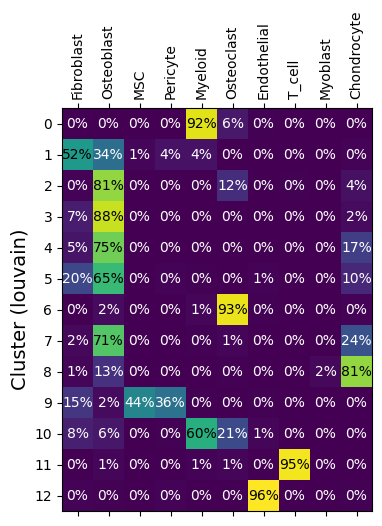

In [73]:
obs_ctype = np.zeros((0,))
obs_cluster = np.zeros((0,))

for name, adata in datasets.items():
    obs_ctype = np.concatenate((obs_ctype, adata.obs['class_type']), axis=0)
    obs_cluster = np.concatenate((obs_cluster, adata.obs['cluster_emuns']), axis=0)

ctypes = set(obs_ctype)
clusters = [str(i) for i in range(len(set(obs_cluster)))]
    
clusters_class = np.zeros((len(clusters), len(ctypes)))
for i, cl in enumerate(clusters):
    items = obs_ctype[obs_cluster == cl]
    for j, ct in enumerate(ctypes):
        clusters_class[i, j] = np.sum(items == ct) / items.shape[0]
  
plt.matshow(clusters_class)
plt.xticks(np.arange(len(ctypes)), ctypes, rotation=90)
plt.yticks(np.arange(len(clusters)), clusters)
plt.ylabel('Cluster (louvain)', fontsize=14)

for i in range(clusters_class.shape[0]):
    for j in range(clusters_class.shape[1]):
        plt.text(
            j, 
            i, 
            f'{int(100*clusters_class[i, j])}%',
            ha='center',
            va='center',
            c=('w' if clusters_class[i, j] < .5 else 'k')
        )
pass

## BBKNN

### Integration

In [ ]:
import scanpy as sc
import anndata as ad

adata_concat = ad.concat(datasets, label='dataset')
sc.tl.pca(adata_concat)
sc.external.pp.bbknn(adata_concat, batch_key='dataset')
sc.tl.umap(adata_concat)

Text(0, 0.5, 'BBKNN + UMAP2')

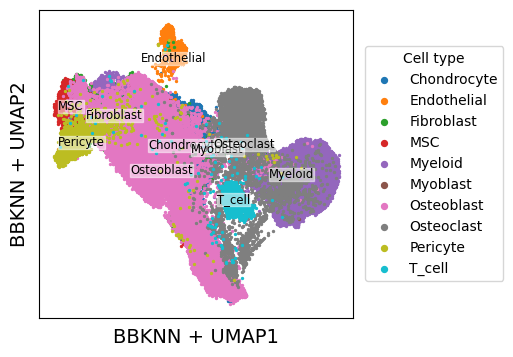

In [122]:
fig = plt.figure(figsize=(4.5,4))
scatter_plot(fig, datasets, "bbknn", "class_type", legend_on_plot=True, legendtitle="Cell type")
plt.xlabel("BBKNN + UMAP1", fontsize=14)
plt.ylabel("BBKNN + UMAP2", fontsize=14)

Text(0, 0.5, 'BBKNN + UMAP2')

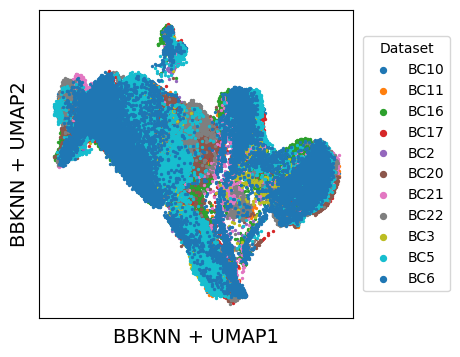

In [124]:
fig = plt.figure(figsize=(4.5,4))
scatter_plot(fig, datasets, "bbknn", "class_type", legendtitle="Dataset", mode="dataset")
plt.xlabel("BBKNN + UMAP1", fontsize=14)
plt.ylabel("BBKNN + UMAP2", fontsize=14)

In [20]:
# Saving results
np.savetxt('data/joint_embedding/bbknn.csv', adata_concat.obsm['X_umap'])

### Clustering

Text(0, 0.5, 'BBKNN + UMAP-2')

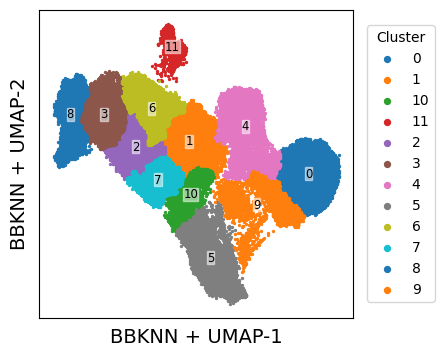

In [74]:
from transmorph.utils.graph import cluster_anndatas

cluster_anndatas(datasets.values(), use_rep="bbknn", cluster_key="cluster_bbknn", resolution=.05)
for adata in datasets.values():
    adata.obs['cluster_bbknn'] = adata.obs['cluster_bbknn'].astype(str)
    
fig = plt.figure(figsize=(4.5,4))
scatter_plot(fig, datasets, "bbknn", "cluster_bbknn", legendtitle="Cluster", legend_on_plot=True)
plt.xlabel("BBKNN + UMAP-1", fontsize=14)
plt.ylabel("BBKNN + UMAP-2", fontsize=14)

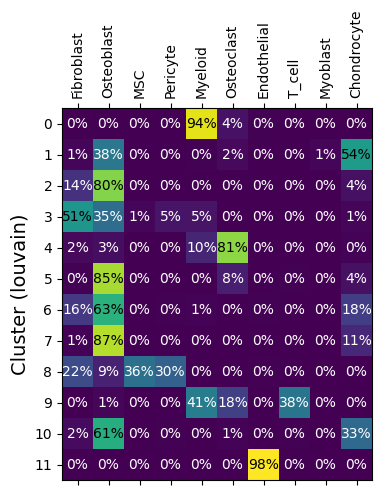

In [75]:
obs_ctype = np.zeros((0,))
obs_cluster = np.zeros((0,))

for name, adata in datasets.items():
    obs_ctype = np.concatenate((obs_ctype, adata.obs['class_type']), axis=0)
    obs_cluster = np.concatenate((obs_cluster, adata.obs['cluster_bbknn']), axis=0)

ctypes = set(obs_ctype)
clusters = [str(i) for i in range(len(set(obs_cluster)))]
    
clusters_class = np.zeros((len(clusters), len(ctypes)))
for i, cl in enumerate(clusters):
    items = obs_ctype[obs_cluster == cl]
    for j, ct in enumerate(ctypes):
        clusters_class[i, j] = np.sum(items == ct) / items.shape[0]
  
plt.matshow(clusters_class)
plt.xticks(np.arange(len(ctypes)), ctypes, rotation=90)
plt.yticks(np.arange(len(clusters)), clusters)
plt.ylabel('Cluster (louvain)', fontsize=14)

for i in range(clusters_class.shape[0]):
    for j in range(clusters_class.shape[1]):
        plt.text(
            j, 
            i, 
            f'{int(100*clusters_class[i, j])}%',
            ha='center',
            va='center',
            c=('w' if clusters_class[i, j] < .5 else 'k')
        )
pass

## HarmonyPy

### Integration

In [5]:
import anndata as ad

adata_all = ad.concat(datasets, label="batch")
adata_all

/home/risitop/.local/share/virtualenvs/transmorph_local-RhkhmxdW/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 64557 × 469
    obs: 'class_type', 'class_iscancer', 'batch'

In [10]:
import scanpy as sc

sc.pp.pca(adata_all)

In [ ]:
import scanpy.external as sce

sce.pp.harmony_integrate(adata_all, key="batch")

In [13]:
sc.pp.neighbors(adata_all, use_rep="X_pca_harmony")

In [15]:
sc.tl.umap(adata_all)

Text(0, 0.5, 'Harmony + UMAP2')

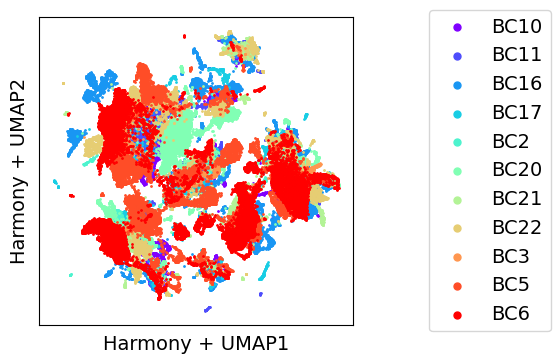

In [19]:
fig = plt.figure(figsize=(4.5,4))
scatter_plot(fig, adata_all, "X_umap", "batch", legendtitle="Cell type")
plt.xlabel("Harmony + UMAP1", fontsize=14)
plt.ylabel("Harmony + UMAP2", fontsize=14)

## HarmonyR

### Integration

In [12]:
!pipenv install rpy2

Installing rpy2...
Adding rpy2 to Pipfile's [packages]...
✔ Installation Succeeded 
Installing dependencies from Pipfile.lock (d38a48)...
  🐍   ▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉ 1/1 — 00:00:05;5;1m▉▉▉▉▉▉▉▉▉▉ 0/1 — 00:00:00


In [4]:
%load_ext rpy2.ipython

In [ ]:
%%R

install.packages(
    "harmony", 
    repos = "http://cran.us.r-project.org", 
    dependencies = TRUE, 
    INSTALL_opts = '--no-lock'
)

In [6]:
%%R

library(harmony)

R[write to console]: Loading required package: Rcpp



In [30]:
import anndata as ad

for name, adata in datasets.items():
    adata.obs["sample"] = name

adata_full = ad.concat(list(datasets.values()), join="inner")

/home/risitop/.local/share/virtualenvs/transmorph_local-RhkhmxdW/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [13]:
from sklearn.decomposition import PCA

X_input = adata_full.X
batch = adata_full.obs["sample"].to_numpy()

In [ ]:
%%R -i X_input -i batch -o harmony_embedding

t1 = Sys.time()
after <- HarmonyMatrix(X_input, batch)
t2 = Sys.time()

harmony_embedding = data.frame(after)

t2 - t1

In [19]:
%%time
import umap

harmony_2d = umap.UMAP(min_dist=0.5).fit_transform(harmony_embedding.to_numpy())

CPU times: user 3min 47s, sys: 49.4 s, total: 4min 36s
Wall time: 30.9 s


In [31]:
adata_full.obsm['harmony'] = harmony_2d

Text(0, 0.5, 'Harmony + UMAP2')

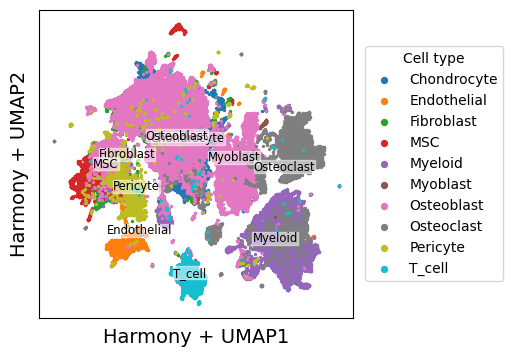

In [125]:
fig = plt.figure(figsize=(4.5,4))
scatter_plot(fig, datasets, "harmony", "class_type", legend_on_plot=True, legendtitle="Cell type")
plt.xlabel("Harmony + UMAP1", fontsize=14)
plt.ylabel("Harmony + UMAP2", fontsize=14)

Text(0, 0.5, 'Harmony + UMAP2')

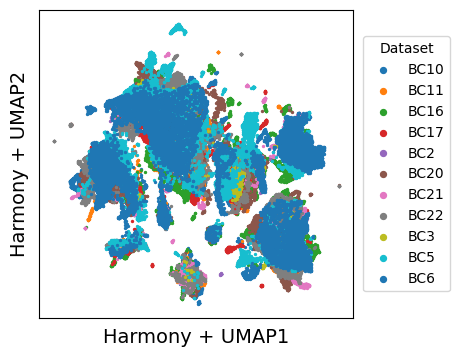

In [128]:
fig = plt.figure(figsize=(4.5,4))
scatter_plot(fig, datasets, "harmony", "class_type", legendtitle="Dataset", mode="dataset")
plt.xlabel("Harmony + UMAP1", fontsize=14)
plt.ylabel("Harmony + UMAP2", fontsize=14)

In [36]:
# Saving results
np.savetxt('data/joint_embedding/harmony.csv', adata_full.obsm['harmony'])

### Clustering

Text(0, 0.5, 'Harmony + UMAP-2')

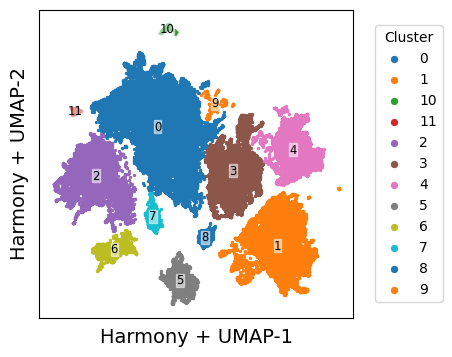

In [83]:
from transmorph.utils.graph import cluster_anndatas

cluster_anndatas(datasets.values(), use_rep="harmony", cluster_key="cluster_harmony", resolution=.005)
for adata in datasets.values():
    adata.obs['cluster_harmony'] = adata.obs['cluster_harmony'].astype(str)
    
obs_ctype = np.zeros((0,))
obs_cluster = np.zeros((0,))

for name, adata in datasets.items():
    obs_ctype = np.concatenate((obs_ctype, adata.obs['class_type']), axis=0)
    obs_cluster = np.concatenate((obs_cluster, adata.obs['cluster_harmony']), axis=0)

for cluster in set(obs_cluster):
    if np.sum(obs_cluster == cluster) < 100:
        for adata in datasets.values(): 
            adata.obs['cluster_harmony'][adata.obs['cluster_harmony'] == cluster] = 'n/a'
    
fig = plt.figure(figsize=(4.5,4))
scatter_plot(fig, datasets, "harmony", "cluster_harmony", legendtitle="Cluster", legend_on_plot=True)
plt.xlabel("Harmony + UMAP-1", fontsize=14)
plt.ylabel("Harmony + UMAP-2", fontsize=14)

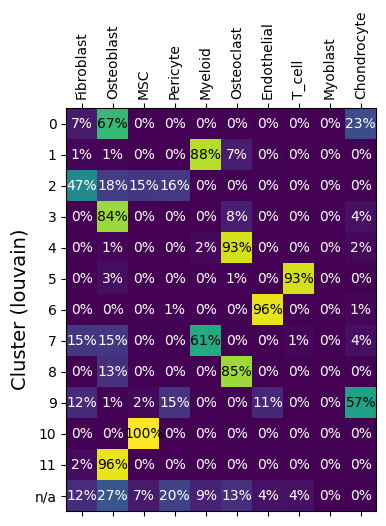

In [94]:
obs_ctype = np.zeros((0,))
obs_cluster = np.zeros((0,))

for name, adata in datasets.items():
    obs_ctype = np.concatenate((obs_ctype, adata.obs['class_type']), axis=0)
    obs_cluster = np.concatenate((obs_cluster, adata.obs['cluster_harmony']), axis=0)

ctypes = set(obs_ctype)
clusters = [str(i) for i in range(len(set(obs_cluster)) - 1)] + ['n/a']
    
clusters_class = np.zeros((len(clusters), len(ctypes)))
for i, cl in enumerate(clusters):
    items = obs_ctype[obs_cluster == cl]
    for j, ct in enumerate(ctypes):
        clusters_class[i, j] = np.sum(items == ct) / items.shape[0]
  
plt.matshow(clusters_class)
plt.xticks(np.arange(len(ctypes)), ctypes, rotation=90)
plt.yticks(np.arange(len(clusters)), clusters)
plt.ylabel('Cluster (louvain)', fontsize=14)

for i in range(clusters_class.shape[0]):
    for j in range(clusters_class.shape[1]):
        plt.text(
            j, 
            i, 
            f'{int(100*clusters_class[i, j])}%',
            ha='center',
            va='center',
            c=('w' if clusters_class[i, j] < .5 else 'k')
        )
pass

## scVI

### Integration

In [4]:
!pipenv install scvi-tools

Installing scvi-tools...
Adding scvi-tools to Pipfile's [packages]...
✔ Installation Succeeded 
Pipfile.lock (d38a48) out of date, updating to (32ab83)...
Locking [dev-packages] dependencies...
Locking [packages] dependencies...
Building requirements...
Resolving dependencies...
✔ Success! 
Updated Pipfile.lock (32ab83)!
Installing dependencies from Pipfile.lock (32ab83)...
  🐍   ▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉ 1/1 — 00:00:05;5;1m▉▉▉▉▉▉▉▉▉▉ 0/1 — 00:00:00


In [2]:
dpath = "/home/risitop/Documents/PHD/data/transmorph_banks/zhou_osteosarcoma/h5ad_raw/"

import os
import anndata

raw_datasets = {}
for fname in os.listdir(dpath):
    raw_datasets[fname.split('.')[0]] = anndata.read_h5ad(f"{dpath}{fname}")

In [8]:
import scvi
import anndata as ad

for name, adata in raw_datasets.items():
    adata.obs["sample"] = name

adata_full = ad.concat(list(raw_datasets.values()), join="inner")
adata_full.obs_names_make_unique()

/home/risitop/.local/share/virtualenvs/transmorph_local-RhkhmxdW/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [11]:
scvi.model.SCVI.setup_anndata(adata_full, layer="counts", batch_key="sample")
vae = scvi.model.SCVI(adata_full, n_layers=2, n_latent=30)
vae.train()

/home/risitop/.local/share/virtualenvs/transmorph_local-RhkhmxdW/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=124 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
/home/risitop/.local/share/virtualenvs/transmorph_local-RhkhmxdW/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 124/124: 100%|████████████████████████████████████████████████████████████████████████████████████| 124/124 [14:28<00:00,  7.05s/it, loss=427, v_num=1]

`Trainer.fit` stopped: `max_epochs=124` reached.


Epoch 124/124: 100%|████████████████████████████████████████████████████████████████████████████████████| 124/124 [14:28<00:00,  7.01s/it, loss=427, v_num=1]
CPU times: user 1h 25min 25s, sys: 28.7 s, total: 1h 25min 53s
Wall time: 14min 29s


In [12]:
%%time
import umap

adata_full.obsm["scVI"] = umap.UMAP(min_dist=.3).fit_transform(vae.get_latent_representation())

CPU times: user 5min 20s, sys: 19.7 s, total: 5min 40s
Wall time: 49.1 s


In [21]:
adata_full

AnnData object with n_obs × n_vars = 64557 × 469
    obs: 'sample', 'cell_type', 'malignant', 'n_genes', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'scVI'
    layers: 'counts'

Text(0, 0.5, 'scVI-2')

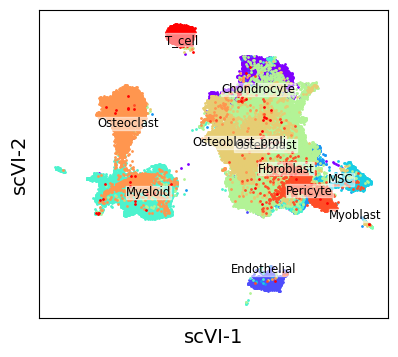

In [28]:
fig = plt.figure(figsize=(4.5,4))
scatter_plot(fig, adata_full, "scVI", "cell_type", legendtitle="Cell type", legend_on_plot=True)
plt.xlabel("scVI-1", fontsize=14)
plt.ylabel("scVI-2", fontsize=14)

Text(0, 0.5, 'scVI-2')

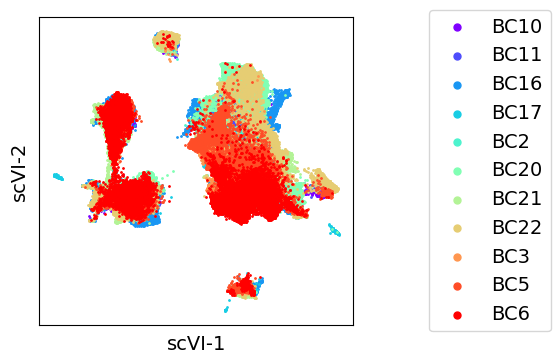

In [25]:
fig = plt.figure(figsize=(4.5,4))
scatter_plot(fig, adata_full, "scVI", "sample", legendtitle="Dataset")
plt.xlabel("scVI-1", fontsize=14)
plt.ylabel("scVI-2", fontsize=14)

In [40]:
# Saving results
np.savetxt('data/joint_embedding/scvi.csv', vae.get_latent_representation())
np.savetxt('data/joint_embedding/scvi_umap.csv', adata_full.obsm['scVI'])

### Clustering

In [42]:
X_full = vae.get_latent_representation()

offset = 0
for adata in datasets.values():
    adata.obsm['scVI'] = X_full[offset:offset + adata.n_obs].copy()
    offset += adata.n_obs

DEBUG:transmorph._logging:ADManager > Inserting <class 'numpy.ndarray'> ((14322,)) in obs[cluster_scVI]
DEBUG:transmorph._logging:ADManager > Inserting <class 'numpy.ndarray'> ((5020,)) in obs[cluster_scVI]
DEBUG:transmorph._logging:ADManager > Inserting <class 'numpy.ndarray'> ((8362,)) in obs[cluster_scVI]
DEBUG:transmorph._logging:ADManager > Inserting <class 'numpy.ndarray'> ((3331,)) in obs[cluster_scVI]
DEBUG:transmorph._logging:ADManager > Inserting <class 'numpy.ndarray'> ((866,)) in obs[cluster_scVI]
DEBUG:transmorph._logging:ADManager > Inserting <class 'numpy.ndarray'> ((1601,)) in obs[cluster_scVI]
DEBUG:transmorph._logging:ADManager > Inserting <class 'numpy.ndarray'> ((10575,)) in obs[cluster_scVI]
DEBUG:transmorph._logging:ADManager > Inserting <class 'numpy.ndarray'> ((3007,)) in obs[cluster_scVI]
DEBUG:transmorph._logging:ADManager > Inserting <class 'numpy.ndarray'> ((6556,)) in obs[cluster_scVI]
DEBUG:transmorph._logging:ADManager > Inserting <class 'numpy.ndarray'> 

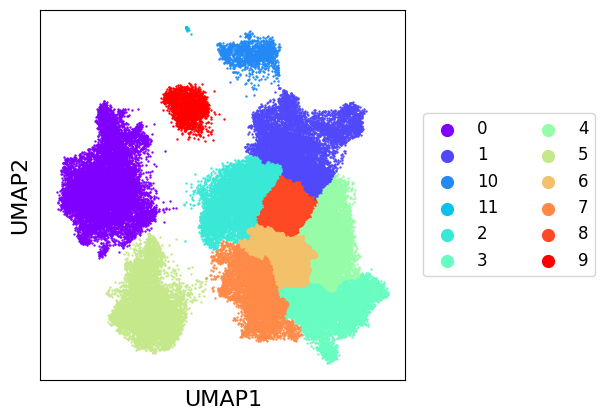

In [49]:
from transmorph.utils.graph import cluster_anndatas
from transmorph.utils.plotting import reduce_dimension, scatter_plot

#reduce_dimension(datasets, input_obsm="scVI", output_obsm="scVI_umap")

cluster_anndatas(datasets.values(), use_rep="scVI_umap", cluster_key="cluster_scVI", resolution=.07)
for adata in datasets.values():
    adata.obs['cluster_scVI'] = adata.obs['cluster_scVI'].astype(str)
    
scatter_plot(datasets, use_rep="scVI_umap", color_by="cluster_scVI")

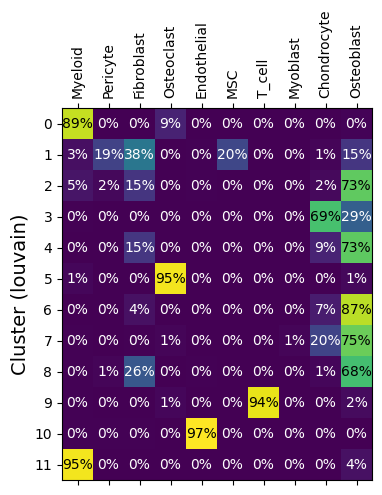

In [50]:
obs_ctype = np.zeros((0,))
obs_cluster = np.zeros((0,))

for name, adata in datasets.items():
    obs_ctype = np.concatenate((obs_ctype, adata.obs['class_type']), axis=0)
    obs_cluster = np.concatenate((obs_cluster, adata.obs['cluster_scVI']), axis=0)

ctypes = set(obs_ctype)
clusters = [str(i) for i in range(len(set(obs_cluster)))]
    
clusters_class = np.zeros((len(clusters), len(ctypes)))
for i, cl in enumerate(clusters):
    items = obs_ctype[obs_cluster == cl]
    for j, ct in enumerate(ctypes):
        clusters_class[i, j] = np.sum(items == ct) / items.shape[0]
  
plt.matshow(clusters_class)
plt.xticks(np.arange(len(ctypes)), ctypes, rotation=90)
plt.yticks(np.arange(len(clusters)), clusters)
plt.ylabel('Cluster (louvain)', fontsize=14)

for i in range(clusters_class.shape[0]):
    for j in range(clusters_class.shape[1]):
        plt.text(
            j, 
            i, 
            f'{int(100*clusters_class[i, j])}%',
            ha='center',
            va='center',
            c=('w' if clusters_class[i, j] < .5 else 'k')
        )
pass

## LISI + time

In [51]:
# We gathered these different wall times
times = {
    'EmbedMNN\nsupervised': 284,
    'EmbedMNN\nunsupervised': 270,
    'BBKNN\n+ UMAP': 80,
    'Harmony\n + UMAP': 360,
    'scVI': 860
}

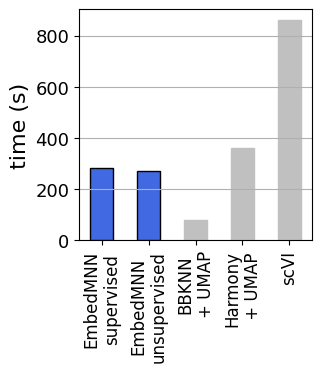

In [52]:
plt.figure(figsize=(3,3))
bars = plt.bar(
    np.arange(5), 
    times.values(),
    width=.5,
    color=['royalblue', 'royalblue', 'silver', 'silver', 'silver'],
    edgecolor=['k', 'k', 'silver', 'silver', 'silver']
)
plt.xticks(np.arange(5), times.keys(), fontsize=12, rotation=90, va="top")
plt.ylabel("time (s)", fontsize=16)
plt.yticks(fontsize=13)
plt.grid(axis='y')
pass

In [5]:
X_emsup = np.loadtxt('data/joint_embedding/embedmnn_supervised.csv')
X_emuns = np.loadtxt('data/joint_embedding/embedmnn_unsupervised.csv')
X_bbknn = np.loadtxt('data/joint_embedding/bbknn.csv')
X_harmony = np.loadtxt('data/joint_embedding/harmony.csv')
X_scvi = np.loadtxt('data/joint_embedding/scvi_umap.csv')

offset = 0
for name, adata in datasets.items():
    n = adata.n_obs
    adata.obsm['emsup'] = X_emsup[offset:offset+n]
    adata.obsm['emuns'] = X_emuns[offset:offset+n]    
    adata.obsm['bbknn'] = X_bbknn[offset:offset+n]    
    adata.obsm['harmony'] = X_harmony[offset:offset+n]    
    adata.obsm['scvi'] = X_scvi[offset:offset+n]    
    offset += n

In [12]:
from transmorph.stats import lisi

In [13]:
lisib = {}
for rep in datasets['BC6'].obsm.keys():
    lisib[rep] = lisi(datasets, obsm=rep, perplexity=30)
for rep in datasets['BC6'].obsm.keys():
    lisib[rep].append(np.concatenate(lisib[rep], axis=0))

In [14]:
lisic = {}
for rep in datasets['BC6'].obsm.keys():
    lisic[rep] = lisi(datasets, obsm=rep, obs='class_type', perplexity=30)
for rep in datasets['BC6'].obsm.keys():
    lisic[rep].append(np.concatenate(lisic[rep], axis=0))

In [15]:
import matplotlib.patches as mpatches

def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

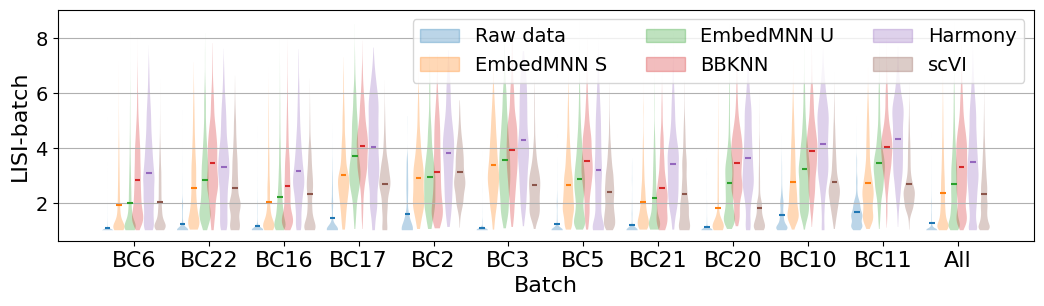

In [16]:
plt.figure(figsize=(14,3))
vp_b_base = plt.violinplot(lisib['base_umap'], positions=np.arange(12)-.35, widths=.15, showmeans=True, showextrema=False)
vp_b_emsup = plt.violinplot(lisib['emsup'], positions=np.arange(12)-.2, widths=.15, showmeans=True, showextrema=False)
vp_b_emuns = plt.violinplot(lisib['emuns'], positions=np.arange(12)-.05, widths=.15, showmeans=True, showextrema=False)
vp_b_bbknn = plt.violinplot(lisib['bbknn'], positions=np.arange(12)+.05, widths=.15, showmeans=True, showextrema=False)
vp_b_harmony = plt.violinplot(lisib['harmony'], positions=np.arange(12)+.2, widths=.15, showmeans=True, showextrema=False)
vp_b_scvi = plt.violinplot(lisib['scvi'], positions=np.arange(12)+.35, widths=.15, showmeans=True, showextrema=False)

labels = []
add_label(vp_b_base, "Raw data")
add_label(vp_b_emsup, "EmbedMNN S")
add_label(vp_b_emuns, "EmbedMNN U")
add_label(vp_b_bbknn, "BBKNN")
add_label(vp_b_harmony, "Harmony")
add_label(vp_b_scvi, "scVI")

plt.xticks(np.arange(12), list(datasets.keys()) + ["All"], fontsize=16)
plt.ylabel('LISI-batch', fontsize=16)
plt.xlabel("Batch", fontsize=16)
plt.yticks(fontsize=14)

ax = plt.gca()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
plt.legend(
    *zip(*labels), 
    ncol=3,
    fontsize=14
)
plt.grid(axis='y')
pass

In [17]:
all_classes = set(np.concatenate([adata.obs['class_type'] for adata in datasets.values()], axis=0))
lisi_c_perclass = {}
for rep in lisic:
    lisi_rep = []
    for ctype in all_classes:
        lisi_ctype = np.zeros((0,))
        for adata, lisi_adata in zip(datasets.values(), lisic[rep]):
            lisi_ctype = np.concatenate((lisi_ctype, lisi_adata[adata.obs['class_type'] == ctype]))
        lisi_rep.append(lisi_ctype)
    lisi_c_perclass[rep] = lisi_rep

In [18]:
for rep in lisic:
    lisi_c_perclass[rep].append(np.concatenate(lisi_c_perclass[rep], axis=0))

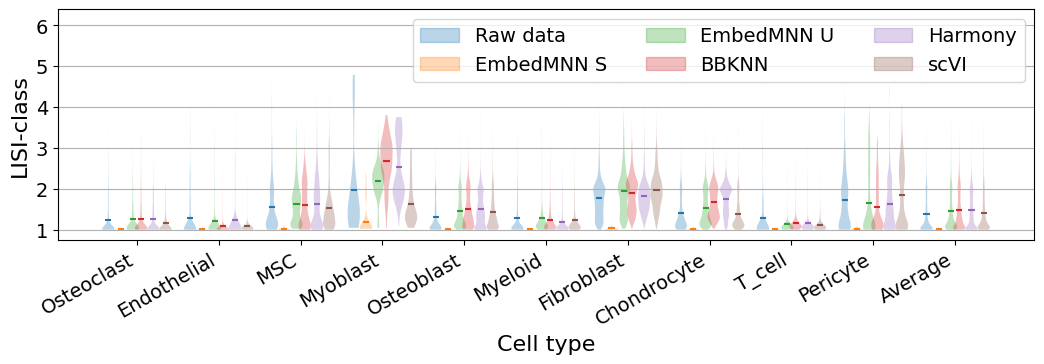

In [19]:
plt.figure(figsize=(14,3))
vp_c_base = plt.violinplot(lisi_c_perclass['base_umap'], positions=np.arange(11)-.35, widths=.15, showmeans=True, showextrema=False)
vp_c_emsup = plt.violinplot(lisi_c_perclass['emsup'], positions=np.arange(11)-.2, widths=.15, showmeans=True, showextrema=False)
vp_c_emuns = plt.violinplot(lisi_c_perclass['emuns'], positions=np.arange(11)-.05, widths=.15, showmeans=True, showextrema=False)
vp_c_bbknn = plt.violinplot(lisi_c_perclass['bbknn'], positions=np.arange(11)+.05, widths=.15, showmeans=True, showextrema=False)
vp_c_harmony = plt.violinplot(lisi_c_perclass['harmony'], positions=np.arange(11)+.2, widths=.15, showmeans=True, showextrema=False)
vp_c_scvi = plt.violinplot(lisi_c_perclass['scvi'], positions=np.arange(11)+.35, widths=.15, showmeans=True, showextrema=False)

labels = []
add_label(vp_c_base, "Raw data")
add_label(vp_c_emsup, "EmbedMNN S")
add_label(vp_c_emuns, "EmbedMNN U")
add_label(vp_c_bbknn, "BBKNN")
add_label(vp_c_harmony, "Harmony")
add_label(vp_c_scvi, "scVI")

plt.xticks(np.arange(11), list(all_classes) + ["Average"], fontsize=14, rotation=30, ha="right")
plt.xlabel("Cell type", fontsize=16)
plt.ylabel('LISI-class', fontsize=16)
plt.yticks(fontsize=14)

ax = plt.gca()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
plt.legend(
    *zip(*labels), 
    ncol=3,
    fontsize=14
)
plt.grid(axis='y')
pass